In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
from pypfopt import EfficientSemivariance, EfficientCVaR, EfficientCDaR, HRPOpt
from pypfopt import risk_models
from pypfopt import expected_returns
from collections import OrderedDict


sns.set(rc={'figure.figsize':(11, 4)})
plt.rcParams['figure.figsize']  = (18, 10)
plt.rcParams['axes.labelsize']  = 20
plt.rcParams['axes.titlesize']  = 20
plt.rcParams['legend.fontsize'] = 20
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams['lines.linewidth'] = 4
plt.ion()
plt.style.use('seaborn-colorblind')
plt.rcParams['figure.figsize']  = (12, 8) # não sei o motivo, mas o use acima reseta o size.

In [ ]:
ANO = 2019

In [ ]:
dados_acoes = pd.read_csv("dados_acoes.csv").set_index("Date")
dados_acoes = dados_acoes[f"{ANO}-01-01":"2021-07-13"].fillna(method="ffill")
dados_acoes.head()

In [ ]:
dados_cripto = pd.read_csv("dados_criptos.csv").set_index("Date")
dados_cripto = dados_cripto[f"{ANO}-01-01":"2021-07-13"].fillna(method="bfill")
dados_cripto.head()

In [ ]:
dados = dados_acoes.join(dados_cripto)
dados.head()

In [ ]:
def gera_portfolio(dados_precos, tipo_dado, tipo='semivariancia', mostra_performance=False):
  in_sample, out_sample = dados_precos[:"2021-01-01"], dados_precos["2021-01-01":]

  mu = expected_returns.mean_historical_return(in_sample)
  historical_returns = expected_returns.returns_from_prices(in_sample)

  if tipo == 'semivariancia':
    es = EfficientSemivariance(mu, historical_returns)
    raw_weights = es.min_semivariance()
  elif tipo =='cvar':
    es = EfficientCVaR(mu, historical_returns)
    raw_weights = es.min_cvar()
  elif tipo == 'cdar':
    es = EfficientCDaR(mu, historical_returns)
    raw_weights = es.min_cdar()
  elif tipo =='hrp':
    es = HRPOpt(historical_returns)
    es.optimize()
    raw_weights = es.clean_weights()
  else:
    raise ValueError("Tipo de portfólio não encotrado!")

  formatted_weights = np.asarray([weight for weight in raw_weights.values()])
  if mostra_performance:
    print(f"{tipo.capitalize()} - {tipo_dado} - Expected performance:")
    es.portfolio_performance(verbose=True)
    print()
  return raw_weights, formatted_weights, out_sample

In [ ]:
from riskfolio import RiskFunctions

def portfolio_metrics(price_data, tipo='semivariancia', rf=0.0575, frequency=252):
  mu = expected_returns.mean_historical_return(price_data.to_frame()).iloc[0]
  returns = price_data.pct_change().dropna()
  actual_return = (price_data.iloc[-1]-price_data.iloc[0])/price_data.iloc[0]
  
  print(f"Actual return: {actual_return:.2%}")
  print(f"Expected annual return: {mu:.2%}")

  if tipo == 'semivariancia':
    drops = np.fmin(returns, 0)
    semivariance = np.sum(np.square(drops)) / returns.shape[0] * frequency
    semi_deviation = np.sqrt(semivariance)
    sortino_ratio = (mu - rf) / semi_deviation

    print("Annual semi-deviation: {:.1f}%".format(100 * semi_deviation))
    print("Sortino Ratio: {:.2f}".format(sortino_ratio))

  elif tipo == 'cvar':
    alpha = 0.95
    var = np.percentile(returns, 100 * (1-alpha))
    cvar_val = np.mean(returns[returns < var])

    print("Conditional Value at Risk: {:.2f}%".format(100 * cvar_val))
  
  elif tipo == 'cdar':
    cdar_val = RiskFunctions.CDaR_Rel(returns)
    print("Conditional Drawdown at Risk: {:.2f}%".format(100 * cdar_val))

  elif tipo == 'hrp':
    sd_p = math.sqrt(risk_models.sample_cov(price_data.to_frame()).iloc[0][0])
    
    print(f"Annual volatility: {sd_p:.2%}")
    print(f"Sharpe ratio: {(mu-rf)/sd_p:.2f}")
    
  else:
    raise ValueError("Tipo de portfólio não encotrado!")

In [ ]:
def backtest(tipo_port: str, tipo_dado: str):
  if tipo_dado == 'crypto':
    data = dados
  elif tipo_dado == 'no_crypto':
    data = dados_acoes
  else:
    raise ValueError("Tipo de dado não encontrado!")

  C = 10_000
  raw_weights, portfolio_weights, out_sample = gera_portfolio(data, tipo_dado, tipo_port, True)
  backtest_range = out_sample.index
  out_sample_returns = out_sample.pct_change().dropna()

  if "BTC-USD" in out_sample_returns.columns and len(portfolio_weights) != 25:
    stock_proportion = 1 - portfolio_weights[-25:].sum()
    equal_stocks = np.repeat(stock_proportion/len(dados_acoes.columns), len(dados_acoes.columns))
    equal_crypto = np.repeat((1 - stock_proportion)/len(dados_cripto.columns), len(dados_cripto.columns))
    equal_weights = np.concatenate((equal_stocks, equal_crypto))
  else:
    equal_weights = np.ones_like(out_sample.columns) / len(out_sample.columns)

  capital = [(C, C)]

  for _, row in out_sample_returns.iterrows():
    portofolio_return, equal_return = np.dot(portfolio_weights, row), np.dot(equal_weights, row)

    C_portfolio, C_equal = capital[-1][0] * (1+portofolio_return), capital[-1][1] * (1+equal_return)
    capital.append((C_portfolio, C_equal))
  

  backtest_df = pd.DataFrame(capital, index=backtest_range, columns=["Portfolio", "Equally Weighted"])

  print("Backtest performance:")
  portfolio_metrics(backtest_df['Portfolio'], tipo_port)
  print()

  backtest_df.plot()
  plt.title(f"Portfolio Value Over Time - {tipo_port.capitalize()} - {tipo_dado}")
  plt.tight_layout()
  plt.savefig(f"graficos2/port_value_{tipo_port}_{tipo_dado}.png")

  return raw_weights

In [ ]:
tipos_port = ['semivariancia', 'cvar', 'cdar', 'hrp']
tipos_dados = ['crypto', 'no_crypto']
pesos = []

for tipo_port in tipos_port:
    for tipo_dados in tipos_dados:
        peso = backtest(tipo_port, tipo_dados)
        pesos.append({"tipo_port": tipo_port, "tipo_dado": tipo_dados, "pesos": peso})

In [ ]:
print(len(pesos))

In [31]:
def print_weights(raw_weights, tipo_port, tipo_dado):
    new_weights = OrderedDict()
    for ticker in raw_weights:
        if raw_weights[ticker] > 0.01:
            new_weights[ticker] = raw_weights[ticker]

    pd.Series(new_weights).plot.barh()
    plt.title(f"Portfolio Composition - {tipo_port.capitalize()} - {tipo_dado}")
    plt.xlabel("Proportion")
    plt.tight_layout()
    plt.savefig(f"graficos2/port_composition_{tipo_port}_{tipo_dado}.png")

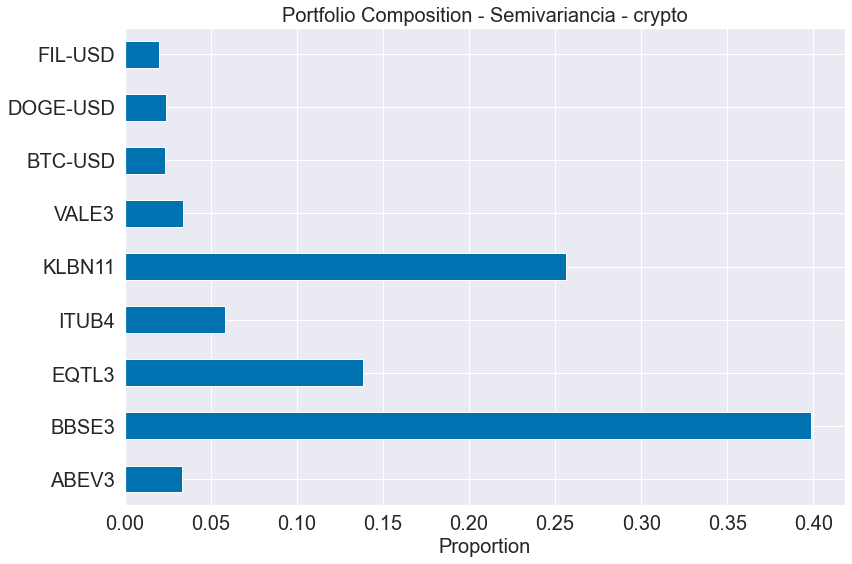

In [32]:
print_weights(pesos[0]['pesos'], pesos[0]['tipo_port'], pesos[0]['tipo_dado'])

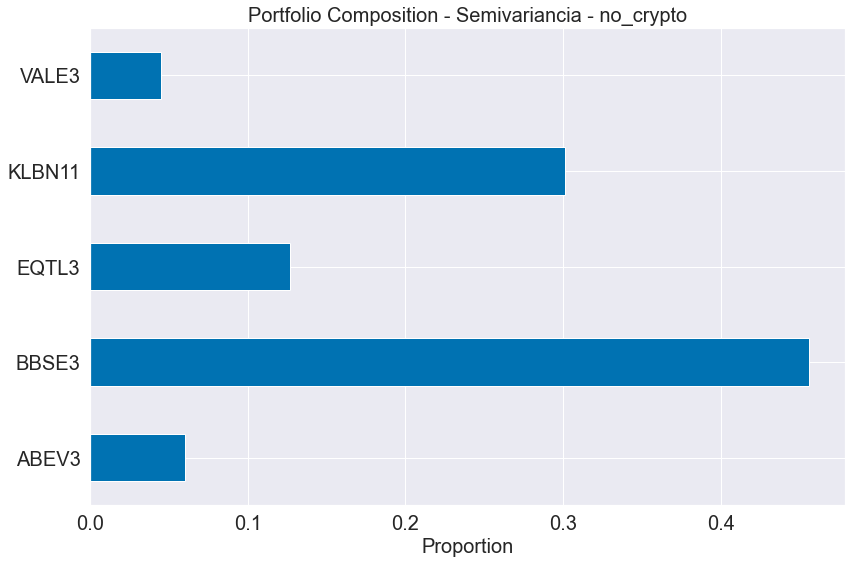

In [33]:
print_weights(pesos[1]['pesos'], pesos[1]['tipo_port'], pesos[1]['tipo_dado'])

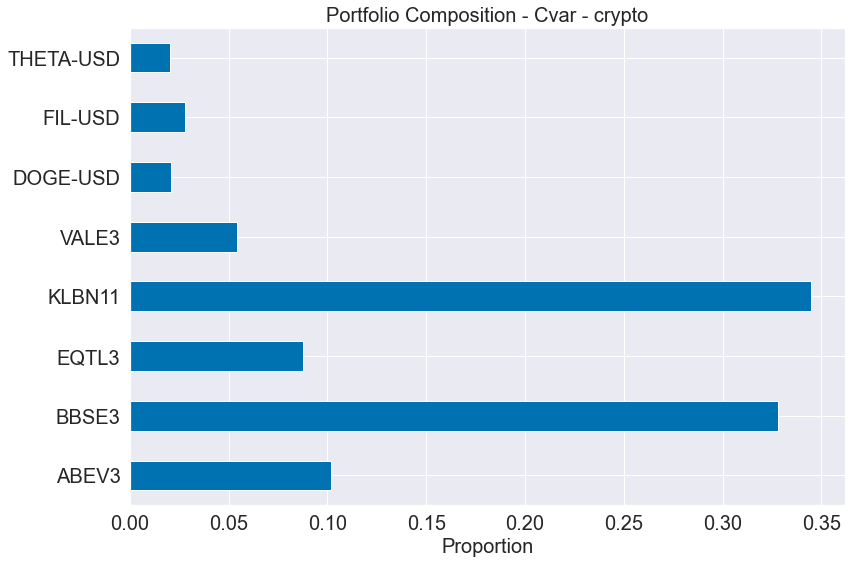

In [34]:
print_weights(pesos[2]['pesos'], pesos[2]['tipo_port'], pesos[2]['tipo_dado'])

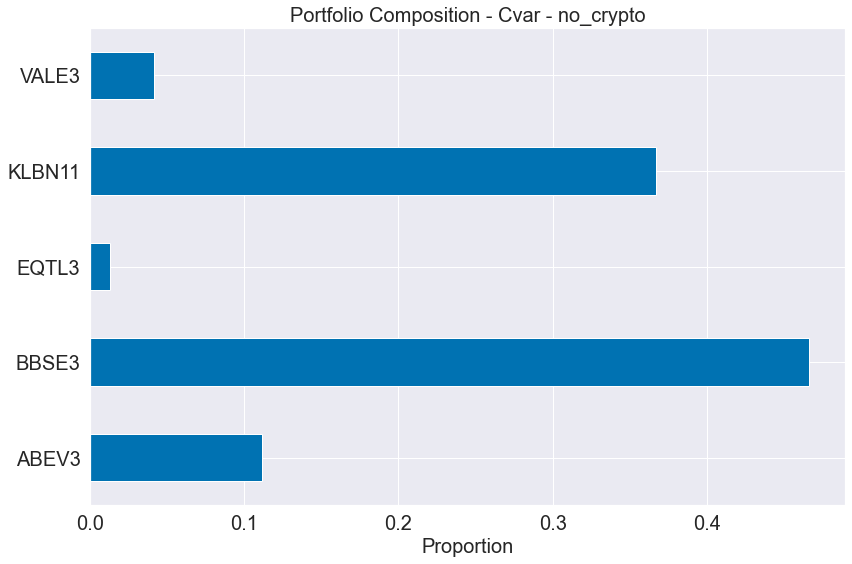

In [35]:
print_weights(pesos[3]['pesos'], pesos[3]['tipo_port'], pesos[3]['tipo_dado'])

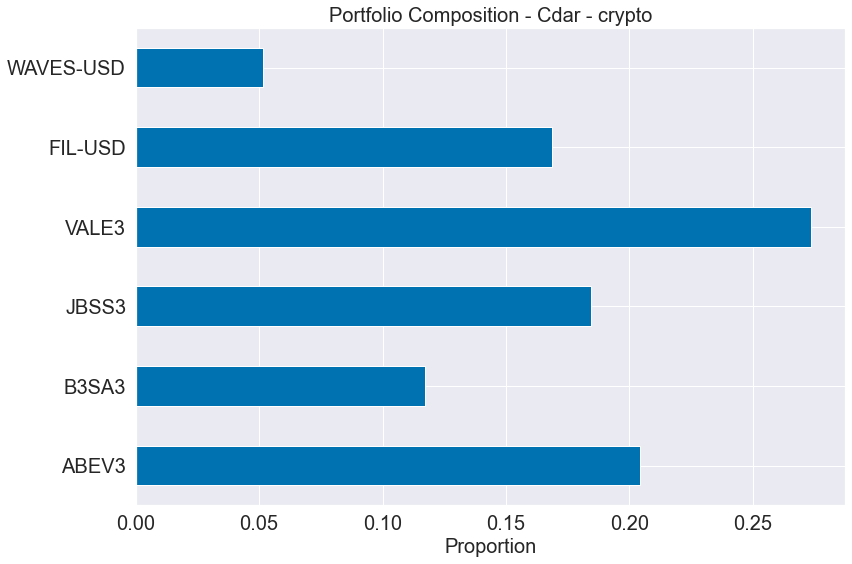

In [36]:
print_weights(pesos[4]['pesos'], pesos[4]['tipo_port'], pesos[4]['tipo_dado'])

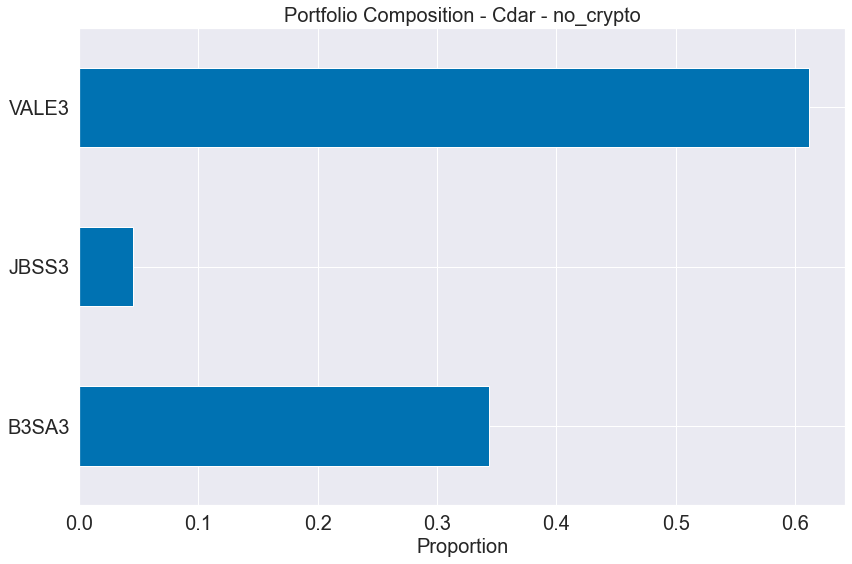

In [37]:
print_weights(pesos[5]['pesos'], pesos[5]['tipo_port'], pesos[5]['tipo_dado'])

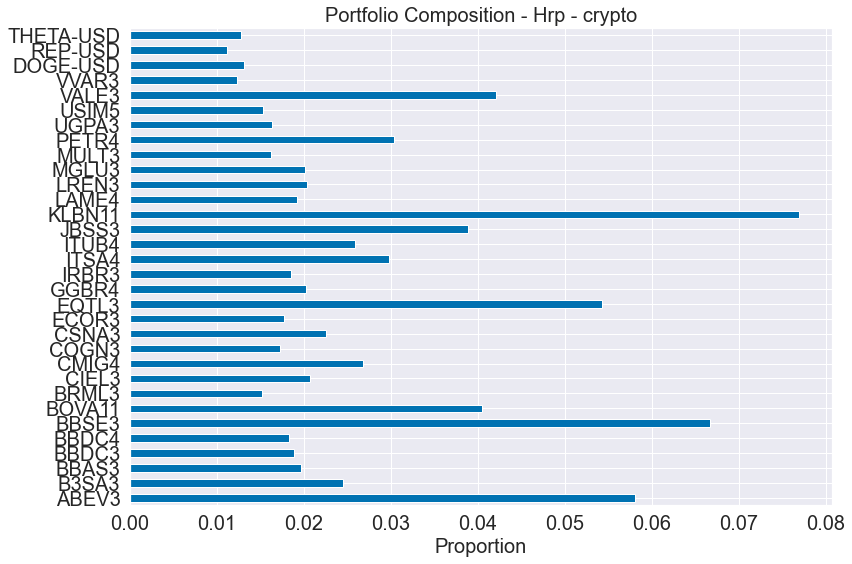

In [38]:
print_weights(pesos[6]['pesos'], pesos[6]['tipo_port'], pesos[6]['tipo_dado'])

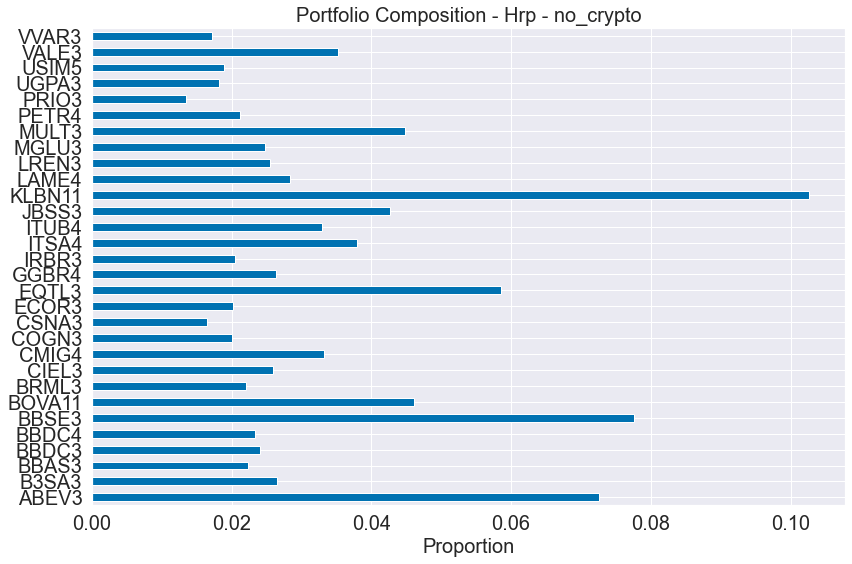

In [39]:
print_weights(pesos[7]['pesos'], pesos[7]['tipo_port'], pesos[7]['tipo_dado'])

In [40]:
def compare_portfolios(tipo_port: str):
  C = 10_000

  _, portfolio_com_cripto, out_sample_cripto = gera_portfolio(dados, "crypto", tipo_port)

  _, portfolio_sem_cripto, out_sample_sem_cripto = gera_portfolio(dados_acoes, "no_crypto", tipo_port)

  backtest_range = out_sample_cripto.index

  out_sample_cripto_returns = out_sample_cripto.pct_change().dropna()
  out_sample_sem_cripto_returns = out_sample_sem_cripto.pct_change().dropna()

  capital = [(C, C)]

  for date in out_sample_cripto_returns.index:
    cripto_row, no_cripto_row = out_sample_cripto_returns.loc[date], out_sample_sem_cripto_returns.loc[date]

    cripto_return, no_cripto_return = np.dot(portfolio_com_cripto, cripto_row), np.dot(portfolio_sem_cripto, no_cripto_row)

    C_cripto, C_no_cripto = capital[-1][0] * (1+cripto_return), capital[-1][1] * (1+no_cripto_return)
    capital.append((C_cripto, C_no_cripto))

  backtest_df = pd.DataFrame(capital, index=backtest_range, columns=["Crypto", "No-Crypto"])

  print(f"Backtest performance - {tipo_port} - Crypto:")
  portfolio_metrics(backtest_df['Crypto'], tipo_port)
  print()
  print(f"Backtest performance - {tipo_port} - No Crypto:")
  portfolio_metrics(backtest_df['No-Crypto'], tipo_port)
  print()


  backtest_df.plot()
  plt.title(f"Portfolio Comparison - {tipo_port.capitalize()}")
  plt.tight_layout()
  plt.savefig(f"graficos2/port_comp_{tipo_port}.png")

Backtest performance - semivariancia - Crypto:
Actual return: 10.16%
Expected annual return: 20.80%
Annual semi-deviation: 12.1%
Sortino Ratio: 1.24

Backtest performance - semivariancia - No Crypto:
Actual return: -4.97%
Expected annual return: -9.48%
Annual semi-deviation: 12.0%
Sortino Ratio: -1.27

Backtest performance - cvar - Crypto:
Actual return: 13.84%
Expected annual return: 28.81%
Conditional Value at Risk: -2.45%

Backtest performance - cvar - No Crypto:
Actual return: -5.46%
Expected annual return: -10.39%
Conditional Value at Risk: -2.36%

Backtest performance - cdar - Crypto:
Actual return: 6.22%
Expected annual return: 12.51%
Conditional Drawdown at Risk: 17.40%

Backtest performance - cdar - No Crypto:
Actual return: 16.43%
Expected annual return: 34.61%
Conditional Drawdown at Risk: 8.76%

Backtest performance - hrp - Crypto:
Actual return: 37.13%
Expected annual return: 85.30%
Annual volatility: 26.12%
Sharpe ratio: 3.05

Backtest performance - hrp - No Crypto:
Actua

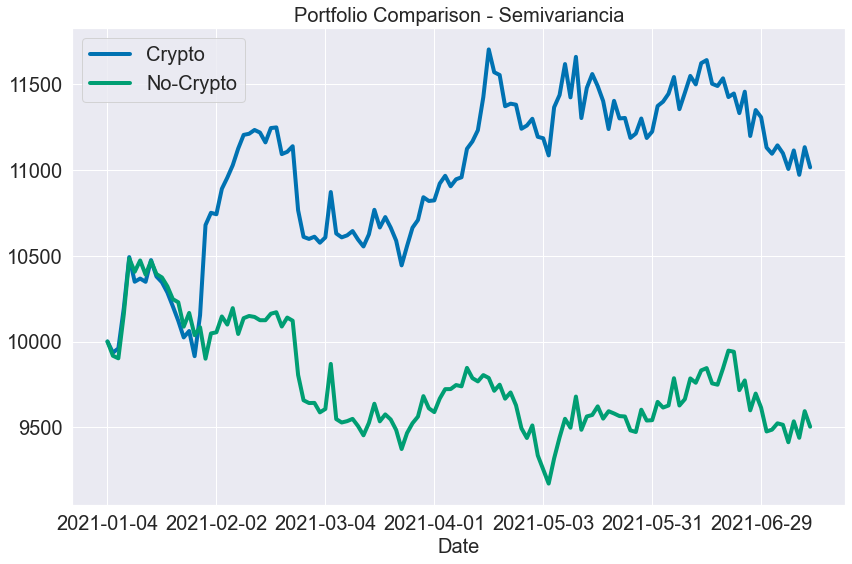

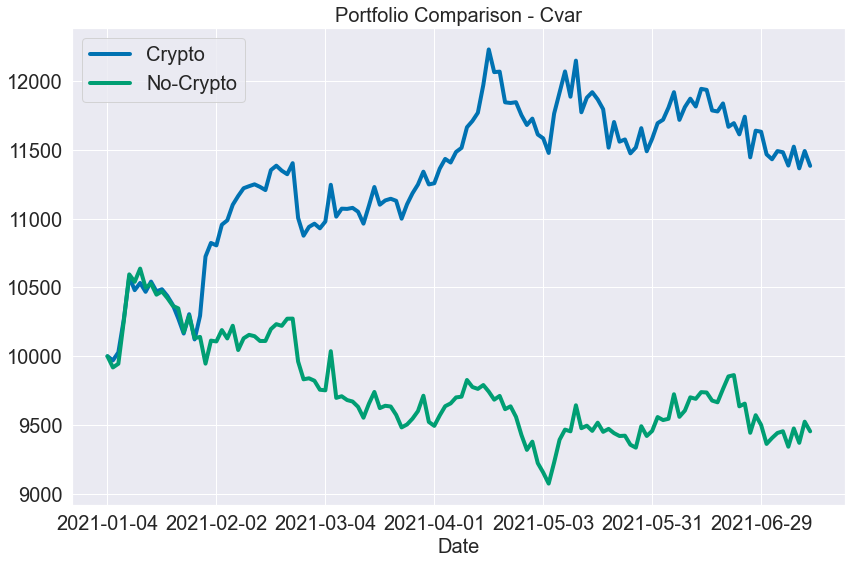

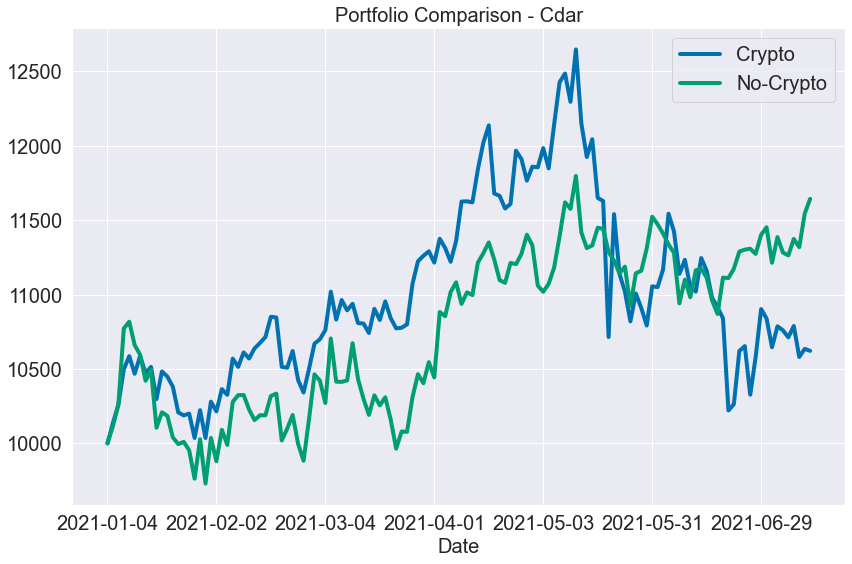

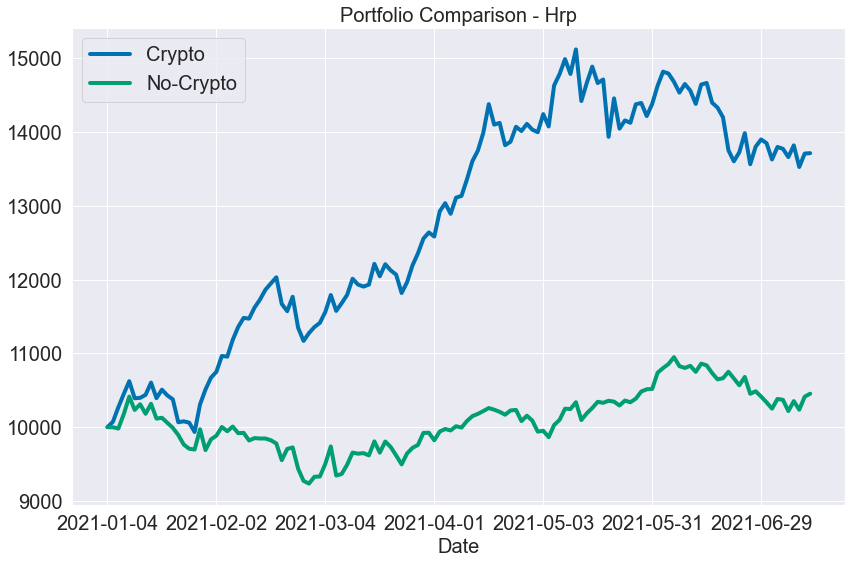

In [41]:
for tipo_port in tipos_port:
    compare_portfolios(tipo_port)